## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
import transformers

from text_data import BertDataset
from albert import CustomAlbert
from learning import Learner
from lr_finder import LRFinder
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [4]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [6]:
num_workers = 10
bs = 2

## Training model

In [7]:
lr = 1e-5
device = 'cuda'
n_epochs = 5
grad_accum = 1
weight_decay = 0.1
model_output_dir = 'albert_1_output/'
pretrained_model = 'siamese_albert_1'
model_name = 'siamese_albert_1_head'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
loss_fn = nn.BCEWithLogitsLoss()

In [8]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(get_optimizer_param_groups(model, lr, weight_decay))

def get_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomAlbert(256, cat_features_train.shape[1])
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model.head

There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


Fold 1 started at Thu Feb  6 21:16:23 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


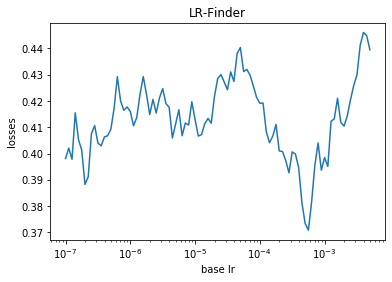

epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45372 - spearmanr 0.4144
best model: epoch -1 - 0.4144
epoch 0: 	 Start training...


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



epoch 0/5 	 train : loss 0.41106 - spearmanr 0.51468
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45299 - spearmanr 0.41601
best model: epoch 0 - 0.41601
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40901 - spearmanr 0.51896
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45334 - spearmanr 0.41612
best model: epoch 1 - 0.41612
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40799 - spearmanr 0.5213
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45354 - spearmanr 0.41598
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40716 - spearmanr 0.52275
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45379 - spearmanr 0.41579
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40646 - spearmanr 0.52435
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45402 - spearmanr 0.41543
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.41612
Starting inference for model: checkpoints/siamese_albert_1_head_fold_1_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 2 started at Thu Feb  6 21:18:29 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45325 - spearmanr 0.42509
best model: epoch -1 - 0.42509
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40956 - spearmanr 0.51659
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45134 - spearmanr 0.42659
best model: epoch 0 - 0.42659
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40707 - spearmanr 0.52121
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45184 - spearmanr 0.42693
best model: epoch 1 - 0.42693
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40622 - spearmanr 0.52266
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45209 - spearmanr 0.42669
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40518 - spearmanr 0.52562
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45264 - spearmanr 0.42657
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40445 - spearmanr 0.52717
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45253 - spearmanr 0.42628
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.42693
Starting inference for model: checkpoints/siamese_albert_1_head_fold_2_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 3 started at Thu Feb  6 21:20:32 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.4561 - spearmanr 0.40607
best model: epoch -1 - 0.40607
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41105 - spearmanr 0.51504
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45423 - spearmanr 0.40816
best model: epoch 0 - 0.40816
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40864 - spearmanr 0.51899
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45507 - spearmanr 0.40773
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40743 - spearmanr 0.52142
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.4555 - spearmanr 0.40711
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40657 - spearmanr 0.52331
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45576 - spearmanr 0.40694
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40594 - spearmanr 0.52462
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45616 - spearmanr 0.40646
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.40816
Starting inference for model: checkpoints/siamese_albert_1_head_fold_3_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 4 started at Thu Feb  6 21:22:34 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45358 - spearmanr 0.40267
best model: epoch -1 - 0.40267
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40979 - spearmanr 0.51907
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45348 - spearmanr 0.40375
best model: epoch 0 - 0.40375
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40737 - spearmanr 0.52312
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45433 - spearmanr 0.40365
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40607 - spearmanr 0.52534
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.4546 - spearmanr 0.40367
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40551 - spearmanr 0.52608
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45493 - spearmanr 0.40361
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40423 - spearmanr 0.52953
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45529 - spearmanr 0.40374
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.40375
Starting inference for model: checkpoints/siamese_albert_1_head_fold_4_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 5 started at Thu Feb  6 21:24:36 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.4547 - spearmanr 0.3995
best model: epoch -1 - 0.3995
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40069 - spearmanr 0.53636
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45561 - spearmanr 0.39949
model not improved for 1 epochs
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40018 - spearmanr 0.53809
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45625 - spearmanr 0.39906
model not improved for 2 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39952 - spearmanr 0.53941
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45658 - spearmanr 0.39881
model not improved for 3 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39881 - spearmanr 0.54053
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45655 - spearmanr 0.39849
model not improved for 4 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39845 - spearmanr 0.54169
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45695 - spearmanr 0.39824
model not improved for 5 epochs
TRAINING END: Best score achieved on epoch -1 - 0.39950
Starting inference for model: checkpoints/siamese_albert_1_head_fold_5_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 6 started at Thu Feb  6 21:26:38 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45299 - spearmanr 0.39648
best model: epoch -1 - 0.39648
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.39788 - spearmanr 0.54465
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45382 - spearmanr 0.39639
model not improved for 1 epochs
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.39694 - spearmanr 0.5461
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45437 - spearmanr 0.39608
model not improved for 2 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39642 - spearmanr 0.54744
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.4547 - spearmanr 0.39599
model not improved for 3 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39575 - spearmanr 0.54897
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45517 - spearmanr 0.3957
model not improved for 4 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39503 - spearmanr 0.5506
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45553 - spearmanr 0.39515
model not improved for 5 epochs
TRAINING END: Best score achieved on epoch -1 - 0.39648
Starting inference for model: checkpoints/siamese_albert_1_head_fold_6_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 7 started at Thu Feb  6 21:28:44 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45807 - spearmanr 0.4161
best model: epoch -1 - 0.4161
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.39701 - spearmanr 0.54347
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45907 - spearmanr 0.41639
best model: epoch 0 - 0.41639
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.39589 - spearmanr 0.5457
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45941 - spearmanr 0.4161
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39512 - spearmanr 0.54739
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.4597 - spearmanr 0.41588
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39466 - spearmanr 0.54824
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.46003 - spearmanr 0.41553
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39392 - spearmanr 0.5496
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.46023 - spearmanr 0.41529
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.41639
Starting inference for model: checkpoints/siamese_albert_1_head_fold_7_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 8 started at Thu Feb  6 21:30:49 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.4595 - spearmanr 0.41896
best model: epoch -1 - 0.41896
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.4086 - spearmanr 0.51744
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.46004 - spearmanr 0.42031
best model: epoch 0 - 0.42031
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40651 - spearmanr 0.52098
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.46048 - spearmanr 0.42
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40552 - spearmanr 0.52345
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.46099 - spearmanr 0.41962
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.4046 - spearmanr 0.52561
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.46138 - spearmanr 0.4193
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40395 - spearmanr 0.52697
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.46176 - spearmanr 0.41899
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.42031
Starting inference for model: checkpoints/siamese_albert_1_head_fold_8_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 9 started at Thu Feb  6 21:32:53 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45329 - spearmanr 0.41285
best model: epoch -1 - 0.41285
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.39833 - spearmanr 0.54265
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4545 - spearmanr 0.4132
best model: epoch 0 - 0.4132
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.39742 - spearmanr 0.54345
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45505 - spearmanr 0.41292
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39702 - spearmanr 0.54474
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45554 - spearmanr 0.41254
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39604 - spearmanr 0.54636
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.4558 - spearmanr 0.41239
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39549 - spearmanr 0.54782
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45584 - spearmanr 0.4121
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.41320
Starting inference for model: checkpoints/siamese_albert_1_head_fold_9_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 10 started at Thu Feb  6 21:34:53 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.44588 - spearmanr 0.41929
best model: epoch -1 - 0.41929
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.39734 - spearmanr 0.5447
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4467 - spearmanr 0.41943
best model: epoch 0 - 0.41943
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.39672 - spearmanr 0.54535
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44723 - spearmanr 0.41888
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39571 - spearmanr 0.54735
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44778 - spearmanr 0.41835
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39531 - spearmanr 0.54861
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44812 - spearmanr 0.41769
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39455 - spearmanr 0.55035
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44832 - spearmanr 0.41765
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.41943
Starting inference for model: checkpoints/siamese_albert_1_head_fold_10_best.pth



OOF score: 0.4127166249259132


In [9]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    
    output_file_path = lambda mode: f'{model_output_dir}{mode}_{pretrained_model}_fold_{fold_id+1}'
    train_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('train')}_q_outputs.npy"),
                    np.load(f"{output_file_path('train')}_a_outputs.npy"), train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('valid')}_q_outputs.npy"),
                    np.load(f"{output_file_path('valid')}_a_outputs.npy"), valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = get_model(fold_id)
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-7, 
                             end_lr=1e-2, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=optim.lr_scheduler.StepLR(optimizer, n_epochs, 0.5), 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=False,
        eval_at_start=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [10]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 8 0.4686243425302676
3 16 0.3014014283656734
5 4 0.45720759667712696
9 64 0.11868612010402654
11 8 0.7559907029009693
12 4 0.4939926529506924
13 32 0.19739526129997104
14 8 0.5965415717405579
15 4 0.5796349230554733
16 16 0.7827106352703415
19 32 0.10562435537176539


In [11]:
np.array(opt_ds), np.array(opt_indices)

(array([ 8, 16,  4, 64,  8,  4, 32,  8,  4, 16, 32]),
 array([ 2,  3,  5,  9, 11, 12, 13, 14, 15, 16, 19]))

In [12]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [13]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.412717
CV unique rows,0.378635
CV ignoring hard targets,0.436188
CV unique rows ignoring hard targets,0.398927
CV w rounding,0.435784
CV unique rows w rounding,0.416138
CV ignoring hard targets w rounding,0.458901
CV unique rows ignoring hard targets w rounding,0.428681


In [14]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.416708
CV unique rows,0.382745
CV ignoring hard targets,0.436188
CV unique rows ignoring hard targets,0.398927
CV w rounding,0.438462
CV unique rows w rounding,0.416374
CV ignoring hard targets w rounding,0.458901
CV unique rows ignoring hard targets w rounding,0.428681


In [15]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [16]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
1,46,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
2,70,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
3,132,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
4,200,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001


In [17]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [18]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.824995,0.839081,0.222960,0.505631,0.549995,0.350547,0.662391,0.585829,0.163218,0.001633,0.678233,0.114722,0.164695,0.054589,0.004002,0.064748,0.139741,0.129808,0.676338,0.000160,0.887810,0.868064,0.559511,0.938501,0.913278,0.669706,0.093739,0.098138,0.850143,0.786066
1,0.850146,0.736160,0.115323,0.636272,0.922460,0.670185,0.563241,0.681138,0.255924,0.001477,0.289376,0.105119,0.854127,0.006253,0.654609,0.063011,0.010212,0.018467,0.363406,0.010331,0.792338,0.574834,0.315407,0.722818,0.785856,0.341089,0.006675,0.016638,0.517173,0.730166
2,0.492040,0.158257,0.009776,0.707171,0.745663,0.826945,0.410036,0.241342,0.124268,0.003949,0.387279,0.319009,0.018759,0.007578,0.001543,0.181276,0.671487,0.307350,0.171864,0.000098,0.398562,0.881699,0.605037,0.927645,0.922824,0.709548,0.646001,0.401489,0.502080,0.699352
3,0.846779,0.770873,0.077598,0.852046,0.751771,0.851513,0.572210,0.647306,0.253346,0.000822,0.310385,0.959705,0.024458,0.027344,0.024472,0.014445,0.049737,0.152382,0.411526,0.003861,0.828489,0.839228,0.749247,0.868535,0.932507,0.787393,0.133111,0.233436,0.728135,0.729860
4,0.799871,0.781214,0.002448,0.698386,0.818497,0.906740,0.479204,0.452842,0.413144,0.000106,0.329290,0.694369,0.001246,0.000534,0.000586,0.004093,0.892503,0.277676,0.080933,0.000007,0.799487,0.779216,0.416838,0.839157,0.929598,0.644063,0.930900,0.164671,0.014530,0.520445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.890434,0.519066,0.194017,0.838707,0.642971,0.650544,0.721485,0.764290,0.408919,0.003322,0.471698,0.917598,0.087033,0.122147,0.016306,0.147373,0.034544,0.089485,0.439211,0.003433,0.709981,0.929897,0.778434,0.959622,0.965449,0.808886,0.066712,0.099371,0.897800,0.772115
6075,0.823117,0.233350,0.099722,0.519149,0.401122,0.441473,0.668441,0.685775,0.115838,0.006604,0.806521,0.017273,0.018316,0.008205,0.000684,0.019847,0.829442,0.425534,0.174332,0.000106,0.596372,0.867721,0.627735,0.948005,0.943039,0.680951,0.808550,0.392319,0.303323,0.830197
6076,0.535346,0.362333,0.001643,0.713402,0.666486,0.921263,0.397547,0.246205,0.161844,0.000933,0.491010,0.689478,0.000252,0.000833,0.000187,0.000887,0.903498,0.366816,0.144640,0.000007,0.356025,0.682032,0.410280,0.890419,0.880723,0.494310,0.700847,0.192230,0.703607,0.606872
6077,0.733128,0.340664,0.730017,0.226476,0.226313,0.100102,0.654028,0.773618,0.895540,0.005587,0.924401,0.634910,0.258844,0.159046,0.063051,0.084121,0.052718,0.333725,0.695917,0.001164,0.684034,0.718131,0.563402,0.820679,0.832294,0.483760,0.025513,0.114151,0.785270,0.760909


In [19]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.384986
question_body_critical                   0.658606
question_conversational                  0.410556
question_expect_short_answer             0.298802
question_fact_seeking                    0.353017
question_has_commonly_accepted_answer    0.419794
question_interestingness_others          0.353835
question_interestingness_self            0.501855
question_multi_intent                    0.584787
question_not_really_a_question           0.102017
question_opinion_seeking                 0.468204
question_type_choice                     0.741295
question_type_compare                    0.360128
question_type_consequence                0.171058
question_type_definition                 0.363915
question_type_entity                     0.451666
question_type_instructions               0.780327
question_type_procedure                  0.356698
question_type_reason_explanation         0.668135
question_type_spelling                   0.066226


In [20]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.066226,3.0
question_not_really_a_question,0.102017,5.0
question_type_consequence,0.171058,5.0
answer_relevance,0.171604,9.0
answer_plausible,0.172004,9.0
answer_well_written,0.213678,9.0
answer_helpful,0.272324,9.0
question_expect_short_answer,0.298802,5.0
answer_type_procedure,0.301835,5.0
question_fact_seeking,0.353017,5.0


In [21]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'question_type_consequence', 'answer_relevance', 'answer_plausible'],
      dtype='object')

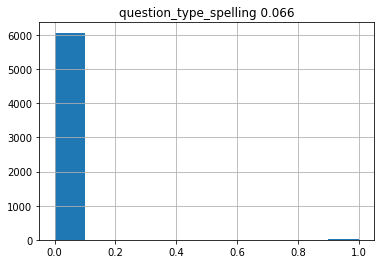

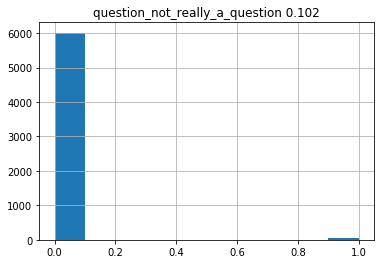

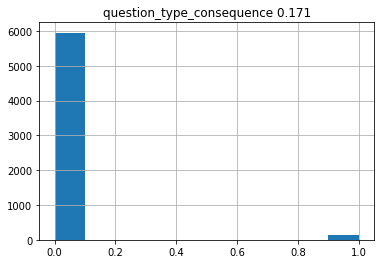

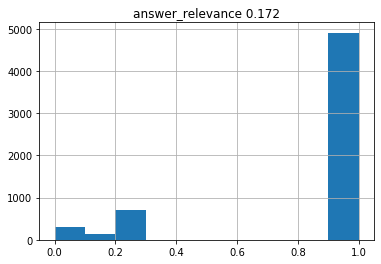

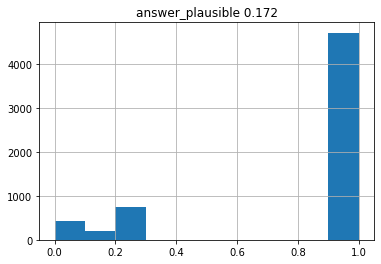

In [22]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


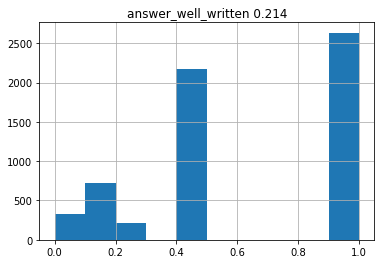

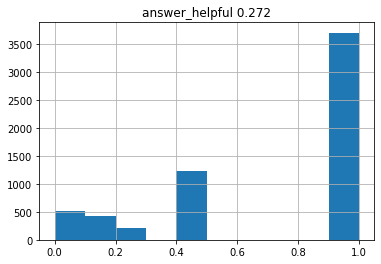

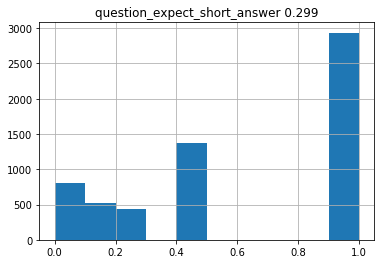

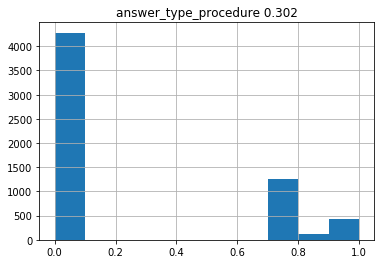

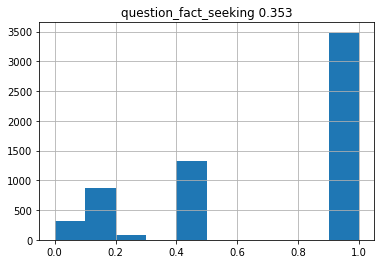

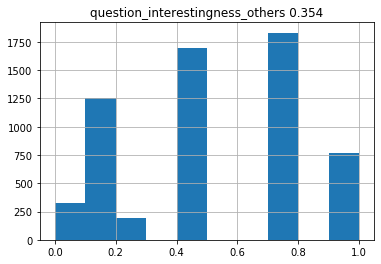

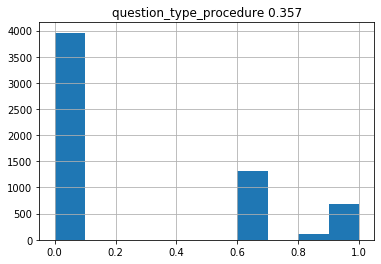

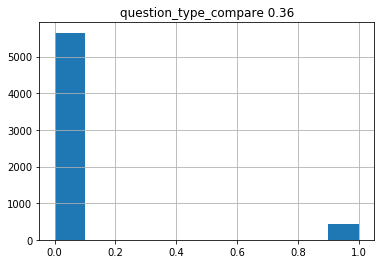

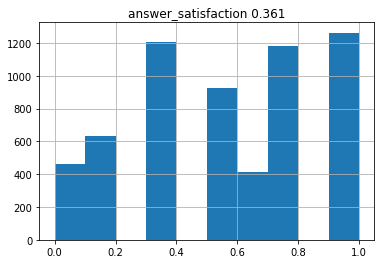

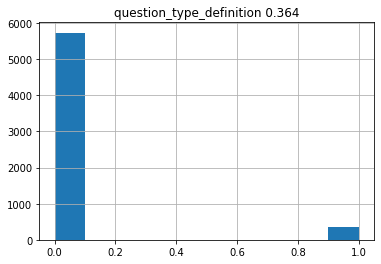

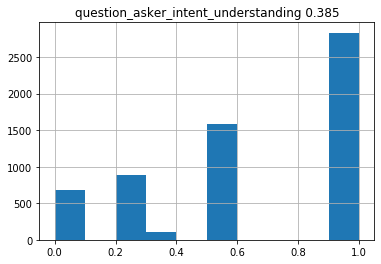

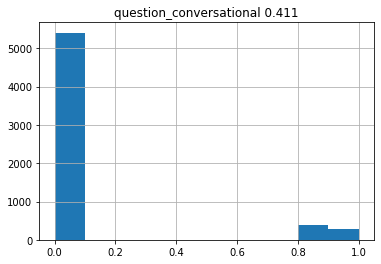

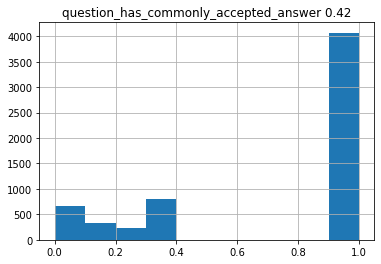

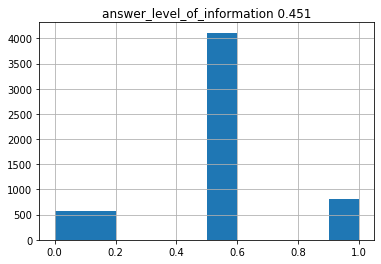

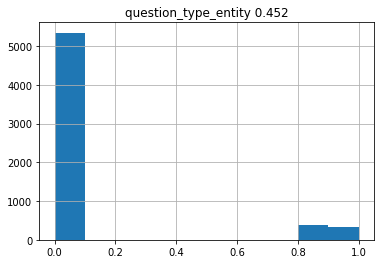

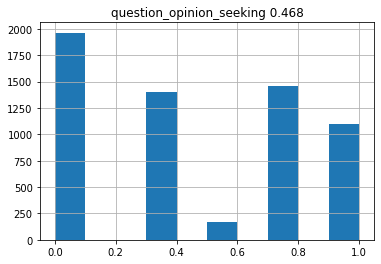

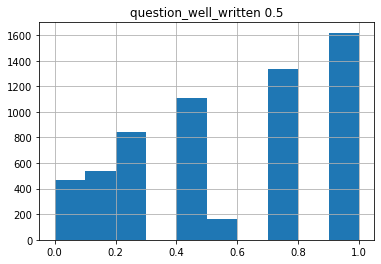

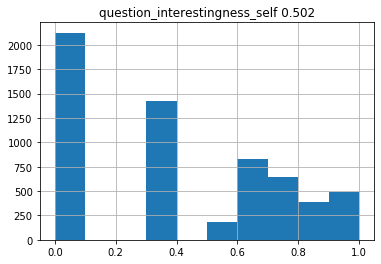

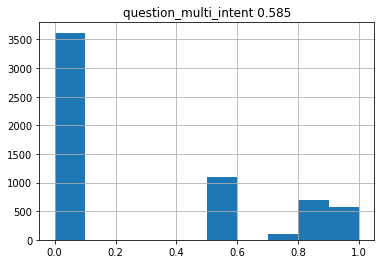

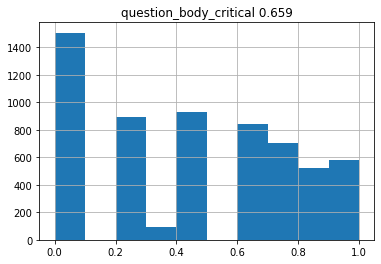

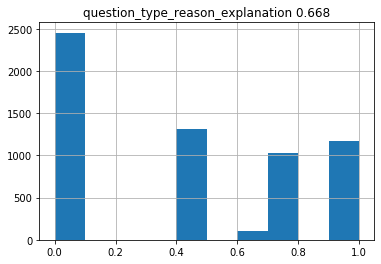

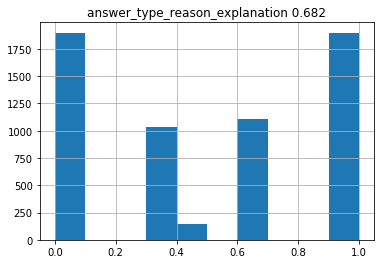

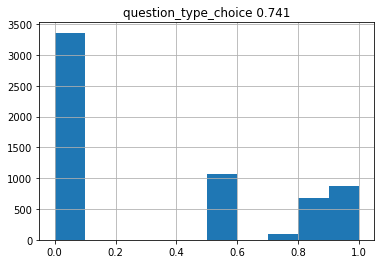

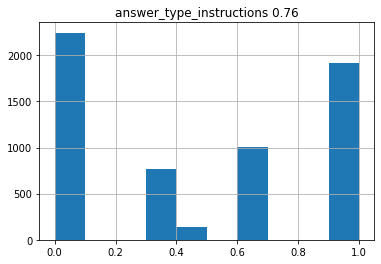

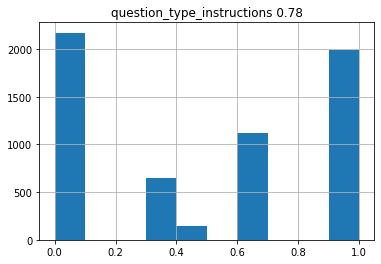

In [23]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')